In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

tensor([-2.0000, -0.5666,  0.6385,  2.0000])
Epoch [100/3000], Loss: 0.035070
Epoch [200/3000], Loss: 0.011790
Epoch [300/3000], Loss: 0.010241
Epoch [400/3000], Loss: 0.010217
Epoch [500/3000], Loss: 0.010210
Epoch [600/3000], Loss: 0.010203
Epoch [700/3000], Loss: 0.010199
Epoch [800/3000], Loss: 0.010199
Epoch [900/3000], Loss: 0.010198
Epoch [1000/3000], Loss: 0.010198
Epoch [1100/3000], Loss: 0.010197
Epoch [1200/3000], Loss: 0.010197
Epoch [1300/3000], Loss: 0.010196
Epoch [1400/3000], Loss: 0.010196
Epoch [1500/3000], Loss: 0.010196
Epoch [1600/3000], Loss: 0.010196
Epoch [1700/3000], Loss: 0.010196
Epoch [1800/3000], Loss: 0.010195
Epoch [1900/3000], Loss: 0.010195
Epoch [2000/3000], Loss: 0.010195
Epoch [2100/3000], Loss: 0.010195
Epoch [2200/3000], Loss: 0.010195
Epoch [2300/3000], Loss: 0.010195
Epoch [2400/3000], Loss: 0.010195
Epoch [2500/3000], Loss: 0.010195
Epoch [2600/3000], Loss: 0.010195
Epoch [2700/3000], Loss: 0.010195
Epoch [2800/3000], Loss: 0.010195
Epoch [2900/

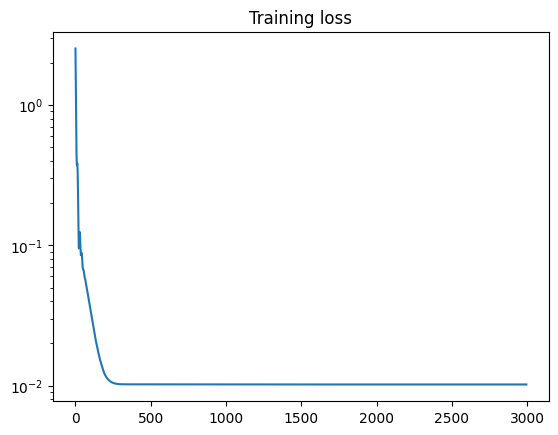

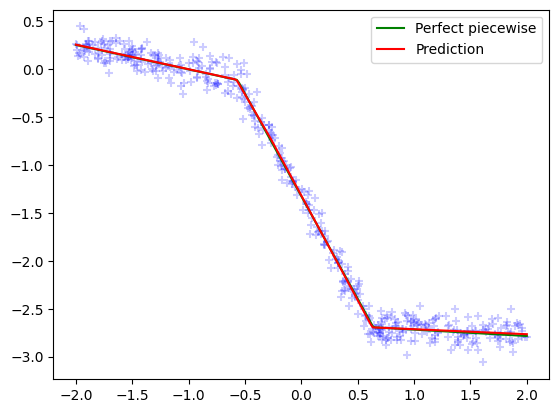

In [20]:
# Define the neural network architecture
import bisect
from typing import Tuple


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear1 = nn.Linear(1, 4)
        # self.linear2 = nn.Linear(2, 2)
        self.linear3 = nn.Linear(4, 1)

    def forward(self, x):
        x = nn.functional.leaky_relu(self.linear1(x), -1)
        # x = nn.functional.leaky_relu(self.linear2(x))
        return self.linear3(x)


num_epochs = 3000

# Create an instance of the model
model = Model()

# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.03)

# Define the learning rate scheduler
scheduler = optim.lr_scheduler.LinearLR(
    optimizer, start_factor=1.0, end_factor=0.01, total_iters=num_epochs
)


# Define the training loop
def train_model(inputs, targets, num_epochs):
    losses = []
    best_loss = torch.inf
    best_loss_epoch = 0
    best_model_weights = None
    early_stop_countdown = 40
    for epoch in range(num_epochs):
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        scheduler.step()

        losses.append(loss.item())

        if best_loss > loss:
            best_loss = loss
            best_loss_epoch = epoch
            best_model_weights = model.state_dict()
        elif epoch - best_loss_epoch > early_stop_countdown:
            print(f"Stopped early at epoch {epoch}")
            break

        # Print the loss for every 10 epochs
        if (epoch + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}")

    model.load_state_dict(best_model_weights)

    plt.plot(range(epoch + 1), losses)
    plt.yscale("log")
    plt.title("Training loss")
    plt.show()


def random_targets(
    pieces: int, sigma: float, size: int
) -> Tuple[torch.Tensor, torch.Tensor]:
    limits = [-2, 2]
    inputs = (limits[1] - limits[0]) * torch.rand((size, 1)) + limits[0]
    boundaries = (
        torch.linspace(limits[0], limits[1], pieces + 1)[1:-1]
        + (torch.rand(pieces - 1) - 0.5) / pieces
    )
    slopes = torch.randn((pieces)) - 0.5
    boundaries = torch.cat([torch.Tensor([-2]), boundaries, torch.Tensor([2])], dim=0)
    boundaries_values = [0] * len(boundaries)
    boundaries_values[0] = torch.rand(1) - 0.5
    for idx in range(len(boundaries) - 1):
        prev_val = boundaries_values[idx]
        boundaries_values[idx + 1] = prev_val + slopes[idx] * (
            boundaries[idx + 1] - boundaries[idx]
        )

    boundaries_list = boundaries.tolist()
    print(boundaries)

    def piecewise_linear(x: float) -> float:
        position = bisect.bisect(boundaries_list, x)
        if position == 0:
            value = slopes[0] * (x - boundaries[0]) + boundaries_values[0]
        elif position == len(boundaries):
            value = (
                slopes[position - 2] * (x - boundaries[position - 1])
                + boundaries_values[position - 1]
            )
        else:
            value = (
                slopes[position - 1] * (x - boundaries[position - 1])
                + boundaries_values[position - 1]
            )
        return value

    targets = torch.tensor([piecewise_linear(x.item()) for x in inputs]).reshape(-1, 1)
    targets += torch.randn(targets.shape) * sigma
    return inputs, targets, piecewise_linear


inputs, targets, piecewise_linear = random_targets(3, 0.1, 500)

# Train the model
train_model(inputs, targets, num_epochs=num_epochs)

plt.scatter(inputs, targets, marker="+", color="blue", alpha=0.2)
x_interval = torch.linspace(-2, 2, 200).reshape(-1, 1)
y_perf = torch.tensor([piecewise_linear(x.item()) for x in x_interval]).reshape(-1, 1)
y_pred = model(x_interval).detach()
plt.plot(x_interval, y_perf, color="green", label="Perfect piecewise")
plt.plot(x_interval, y_pred, color="red", label="Prediction")
plt.legend()
plt.show()